In [14]:
! hostname
%matplotlib inline
%reload_ext autoreload
%autoreload 2

a00757.science.domain


In [15]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

torch.backends.cudnn.benchmark=True

In [16]:
PATH = Path('erda/data/2dsim')

## Here's some U-Nets

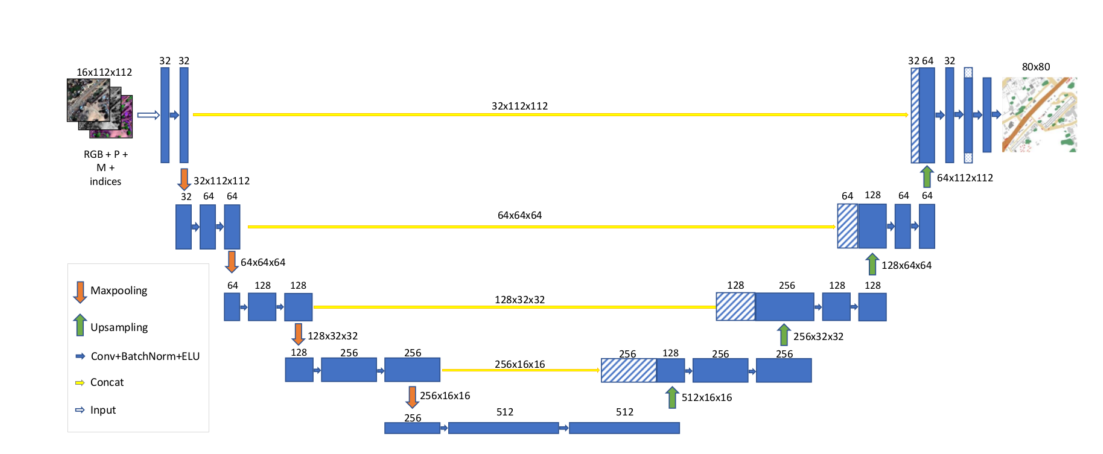

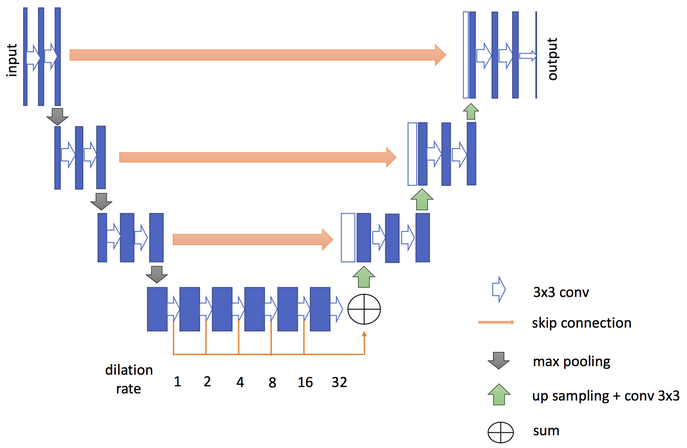

In [17]:
class StdBlock(nn.Module):
    def __init__(self, nin, nout=None):
        super().__init__()
        self.nin=nin
        self.nout = nin if nout is None else nout
        self.conv = nn.Conv2d(self.nin, self.nout, kernel_size=3,padding=1)
        self.bn = nn.BatchNorm2d(self.nout)
    
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

class StdDownsample(nn.Module):
    def __init__(self, nin):
        super().__init__()
        self.nin=nin
        self.pool = nn.AvgPool2d(2, padding=0)
        self.bn = nn.BatchNorm2d(nin)
        
    def forward(self, x): return self.bn(self.pool(x))

class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.nin=nin
        self.nout=nout
        self.conv = nn.ConvTranspose2d(self.nin, self.nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(self.nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))
    
class DilationBlock(nn.Module):
    def __init__(self, nin, nout=None, ndil=3):
        super().__init__()
        self.convs=nn.ModuleList()
        self.nin=nin
        self.nout = nin if nout is None else nout
        for i in range(ndil):
            d=2**i
            l=StdBlock(self.nin,self.nout)
            l.conv.dilation=(d,d)
            l.conv.padding=(d,d)
            self.convs.append(l)
    
    def forward(self, x):
#         import pdb; pdb.set_trace()
        act=self.convs[0](x)
        for li in range(1,len(self.convs)):
            act.add_(self.convs[li](x))
#         test_equality = sum([l(x) for l in self.convs])
#         assert np.allclose(test_equality.data.numpy(),act.data.numpy())
        return act

## test our standard building blocks

In [5]:
# x is a batch with 3 images, 3 channels per image, 128x128 size 
x = V(torch.randn((3,3,128,128))).cpu()
conv1=StdBlock(3,50).cpu()
conv2=StdBlock(50,100).cpu()
ds = StdDownsample(50).cpu()
us = StdUpsample(100,100).cpu()
dil=DilationBlock(50).cpu()
x=conv1(x)
print("conv1 ",x.shape)
b1 = x
x=ds(x)
print("downsample ",x.shape)
x=conv2(x)
print("conv2 ",x.shape)
x=us(x)
print("upsample ", x.shape)
x=torch.cat([b1,x],dim=1)
print("concat ", x.shape)
d=dil(b1)
print("dilation ", d.shape)
del x,b1

conv1  torch.Size([3, 50, 128, 128])
downsample  torch.Size([3, 50, 64, 64])
conv2  torch.Size([3, 100, 64, 64])
upsample  torch.Size([3, 100, 128, 128])
concat  torch.Size([3, 150, 128, 128])
dilation  torch.Size([3, 50, 128, 128])


# Now we have all the building blocks, time to put the U-Net together

In [18]:
class UNet(nn.Module):
    def __init__(self, nin, nout, sz=128, ndil=3):
        super().__init__()
        self.nin = nin
        self.nout= nout
        self.img_sz=sz
        self.n_dilations = ndil
        self.conv1=nn.Sequential(StdBlock(self.nin,32),StdBlock(32,32)) # sz 128
        self.down1=nn.Sequential(StdDownsample(32),StdBlock(32,64),StdBlock(64,64)) #sz 64
        self.down2=nn.Sequential(StdDownsample(64),StdBlock(64,128),StdBlock(128,128)) #sz 32
        self.down_dil_up=nn.Sequential(StdDownsample(128),StdBlock(128,512),DilationBlock(512)
                                      ,StdUpsample(512,256)) #sz 32
        self.up1=nn.Sequential(StdBlock(128+256,128),StdBlock(128,128),StdUpsample(128,128)) #sz 32
        self.up2=nn.Sequential(StdBlock(64+128,64),StdBlock(64,64),StdUpsample(64,64)) #sz 64
        self.conv2=nn.Sequential(StdBlock(32+64,32),StdBlock(32,32),StdBlock(32,self.nout)) #sz 128
    
    def forward(self, x):
        # the layers of the pyramid
        p1 = self.conv1(x) # sz 128
        p2 = self.down1(p1) # sz 64
        p3 = self.down2(p2) # sz 32
        x = self.down_dil_up(p3) # sz 32
        x = self.up1(torch.cat([x,p3],dim=1)) # sz 64
        x = self.up2(torch.cat([x,p2],dim=1)) # sz 128
        x = self.conv2(torch.cat([x,p1],dim=1))
        return x

        

## Test that our UNet works for the full forward pass

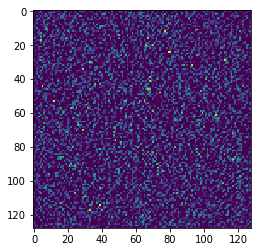

In [8]:
x = V(torch.randn((64,3,128,128))).cuda()
net = UNet(3,1).cuda()
plt.imshow(net(x).data.cpu().numpy()[0][-1])
del x, net
torch.cuda.empty_cache()

# let's load some data from HDF5

In [19]:
import h5py
h5py.enable_ipython_completer()

class SimulationHdf5Dataset(BaseDataset):
    """Custom Dataset for loading entries from HDF5 databases"""

    def __init__(self, h5_path, transform=None):
        self.h5f = h5py.File(h5_path, 'r')
        super().__init__()
        self.transform = transform
        self.body_shape = self.h5f['bodies'].shape[1:]
        self.contact_shape = self.h5f['contacts'].shape[1:]
        self.body_channels=[self.h5f['body_channels'][i][0].decode('utf-8')
                            for i in range(self.h5f['body_channels'].shape[0])]
        self.contact_channels=[self.h5f['contact_channels'][i][0].decode('utf-8')
                               for i in range(self.h5f['contact_channels'].shape[0])]


#     def __getitem__(self, index):
        
#         features = self.h5f['bodies'][index]
#         label = self.h5f['contacts'][index]
#         if self.transform is not None:
#             import pdb; pdb.set_trace()
#             features = self.transform(features)
#         return features, label
    
    def get_n(self):
        return len(self.h5f['sim_fr'])
    
    def get_x(self, i):
        return self.h5f['bodies'][i]
    
    def get_y(self, i):
        return self.h5f['contacts'][i]
    
    def get_c(self):
        return 0
    
    def get_sz(self):
        return self.h5f['bodies'][0].shape[2]
    
    @property
    def is_multi(self): return False

    @property
    def is_reg(self): return True

In [20]:
class PadToEvenShapeTransform(Transform):
    def __init__(self, tfm_y=TfmType.PIXEL):
        self.tfm_y=tfm_y
        self.store = threading.local()
    
    def do_transform(self, x, is_y):
        import pdb; pdb.set_trace()
        if x.shape[1]%2 == 1:
            h_shape = x.shape[1]+1 
        if x.shape[2]%2 == 1:
            w_shape = x.shape[2]+1
        depth = x.shape[0]
        result = np.zeros(())

In [12]:
!cp "erda/data/2dsim/xml1515100_res0.125_h0.5.hdf5" "/tmp/xml1515100_res0.125_h0.5.hdf5"
SIMDATA='/tmp/xml1515100_res0.125_h0.5.hdf5'
ds = SimulationHdf5Dataset(SIMDATA)
x,y = ds[:,:,:,:]
m_x = np.mean(x,axis=(0,2,3))
m_y= np.mean(y,axis=(0,2,3))
s_x = np.std(x,axis=(0,2,3))
s_y = np.std(y,axis=(0,2,3))
len(ds), ds.body_shape, ds.contact_shape, ds.body_channels, ds.contact_channels

(13822,
 (6, 121, 121),
 (4, 121, 121),
 ['mass', 'inertia', 'vx', 'vy', 'theta', 'omega'],
 ['nx', 'ny', 'ni', 'ti'])

In [21]:
# quick and dirty make even shape
t_sz = x.shape[0:2] + (128,128)
tmp = np.zeros(t_sz)
tmp[:,:,0:(x.shape[2]),0:(x.shape[3])]=x

x=tmp

t_sz = y.shape[0:2] + (128,128)

tmp = np.zeros(t_sz)
tmp[:,:,0:y.shape[2],0:y.shape[3]]=y
y=tmp
del tmp

# # quick and dirty normalize
x= np.moveaxis(((np.moveaxis(x, 1, -1) - m_x)/s_x), -1, 1)
y= np.moveaxis(((np.moveaxis(y, 1, -1) - m_y)/s_y), -1, 1)
# del x,y

In [22]:
# the test-validation-train split
val_idxs = get_cv_idxs(len(ds),val_pct=0.08) # 10% of the data for the test set
test_idxs,tr_idxs = split_by_idx(val_idxs,np.arange(len(ds)))[0]
val_idxs = get_cv_idxs(len(tr_idxs),val_pct=0.2) # 20% of the remaining for validation, rest for train
val_idxs, tr_idxs = split_by_idx(val_idxs,tr_idxs)[0]
# test_idxs,val_idxs,tr_idxs, \
test_idxs.shape,val_idxs.shape,tr_idxs.shape

((1105,), (2543,), (10174,))

In [23]:
stats_x = (m_x, s_x)
stats_y = (m_y, s_y)
trn_tfm, val_tfm = tfms_from_stats(stats_x, 6,
                                   crop_type=CropType.NO,
                                   aug_tfms=[PadToEvenShapeTransform],
                                   tfm_y=TfmType.NO, scale=[])
# don't reorder the channels
trn_tfm.tfms =[s for s in trn_tfm.tfms if "ChannelOrder" not in str(type(s))]
trn_tfm.tfms =[s for s in trn_tfm.tfms if "NoCrop" not in str(type(s))]
val_tfm.tfms = [s for s in val_tfm.tfms if "ChannelOrder" not in str(type(s))]
val_tfm.tfms = [s for s in val_tfm.tfms if "NoCrop" not in str(type(s))]
trn_tfm.tfms

[__main__.PadToEvenShapeTransform,

In [24]:
bs=64

class ImageArraysDataset(ArraysDataset):
    def __init__(self, x, y, transform):
        super().__init__(x, y, transform)
        
    def get_c(self): return 0
    
    def get_sz(self): return self.x.shape[2]

datasets = ImageData.get_ds(ImageArraysDataset,
                 trn=(x[tr_idxs],y[tr_idxs]),
                 val= (x[val_idxs],y[val_idxs]),
                 test=(x[test_idxs],y[test_idxs]),
                 tfms=(trn_tfm, val_tfm)                
                )

md = ImageData(PATH/'train', datasets, bs, num_workers=4, classes=None)

In [25]:
from torch.utils.data.dataset import Subset

bs=64
train_loader = torch.utils.data.DataLoader(dataset=TensorDataset(torch.from_numpy(x[tr_idxs]).float(),
                                                torch.from_numpy(y[tr_idxs]).float()),
                          batch_size=bs,
                          shuffle=True,
                          num_workers=4)
val_loader = torch.utils.data.DataLoader(dataset=TensorDataset(torch.from_numpy(x[val_idxs]).float(),
                                              torch.from_numpy(y[val_idxs]).float()),
                          batch_size=bs,
                          shuffle=False,
                          num_workers=4)

test_loader = torch.utils.data.DataLoader(dataset=TensorDataset(torch.from_numpy(x[test_idxs]).float(),
                                               torch.from_numpy(y[test_idxs]).float()),
                          batch_size=bs,
                          shuffle=False,
                          num_workers=4)

In [26]:
md = ModelData(path=PATH,trn_dl=train_loader, val_dl=val_loader, test_dl=test_loader)
net = UNet(6,4)
learn= Learner.from_model_data(m=net, data=md)


In [23]:
learn.crit = F.mse_loss
learn.lr_find(start_lr=1, end_lr=100)

 47%|████▋     | 75/159 [00:23<00:24,  3.48it/s, loss=3.49] 

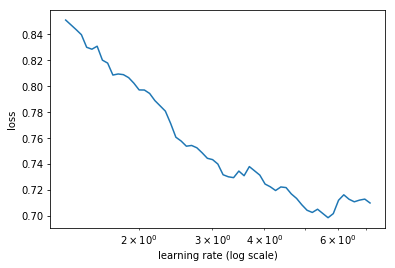

In [24]:
learn.sched.plot()

In [25]:
lr=1

In [67]:
learn.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                                
    0      0.049284   0.016094  
    1      0.061939   0.014073                                
    2      0.03431    0.009172                                
    3      0.032038   0.006978                                
    4      0.037331   0.007401                                


[array([0.0074])]

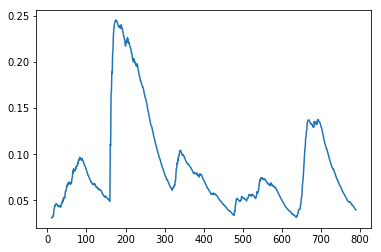

In [68]:
learn.sched.plot_loss()

In [58]:
learn.save("19feb_goodwork")

In [66]:
learn.load("19feb_goodwork")

In [69]:
test_preds = learn.predict(is_test=True)

In [70]:
a,b = next(iter(test_loader))
test_dim = 0
idx = 0

In [94]:
def show_colormap(I):
    plt.imshow(I,cmap='seismic')
    plt.colorbar()

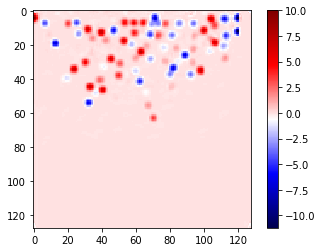

In [96]:
Yhat = learn.model(V(a)).data.cpu()[idx,test_dim]
show_colormap(Yhat)

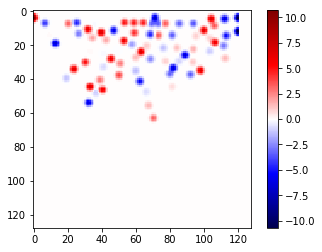

In [97]:
Y=b[idx,test_dim]
show_colormap(Y)

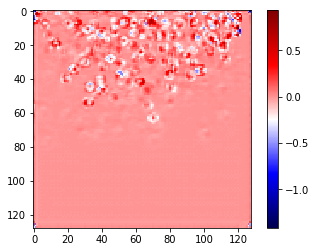

In [98]:
show_colormap(Yhat-Y)